# image reconstruction

## Import libraries

In [39]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os
import random
import copy

## Load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2


In [53]:
directory_data  = './'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

clean_image_train = data['label_train']
input_image_test  = data['input_test'] 
clean_image_test  = data['label_test']

In [54]:
print(clean_image_train.shape)
print(input_image_test.shape)
print(clean_image_test.shape)

(800, 128, 128)
(400, 128, 128)
(400, 128, 128)


input_train 데이터셋 만들기

In [44]:
def idx_list(input_image_test, idx):
  #temp_input_test에서 0로 채워진 row 찾기
  col_idx_list = []
  row_idx_list = []
  #col
  col_idx_list.append([i for i, value in enumerate(input_image_test[idx][0]) if value == 0])
  #row
  row_idx_list.append([i for i, value in enumerate(input_image_test[idx][:,0]) if value == 0])
  
  idx_list = {'idx':idx, 'row': row_idx_list, 'col': col_idx_list}

  return idx_list

In [56]:
def generate_input_train(clean_image_train, idx_list, offset):
  #col과 row를 0으로 변환
  idx = idx_list['idx']+offset
  row_idx_list = idx_list['row']
  col_idx_list = idx_list['col']
  input_train_single = copy.deepcopy(clean_image_train[idx])
  #row
  for i in row_idx_list:
    input_train_single[i] = 0
  #col
  for i in col_idx_list:
    input_train_single[:,i] = 0


  return input_train_single


In [55]:
test_blurr = []
for i in range(len(input_image_test)):
  test_blurr.append(idx_list(input_image_test, i))

len(test_blurr)

400

In [59]:
input_image_train=[]
for i in test_blurr:
  input_image_train.append(generate_input_train(clean_image_train, i,0))
for i in test_blurr:
  input_image_train.append(generate_input_train(clean_image_train, i,400))
  
len(input_image_train)

800

## plot data

In [72]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 6
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
            axes[r, c].imshow(image[k], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

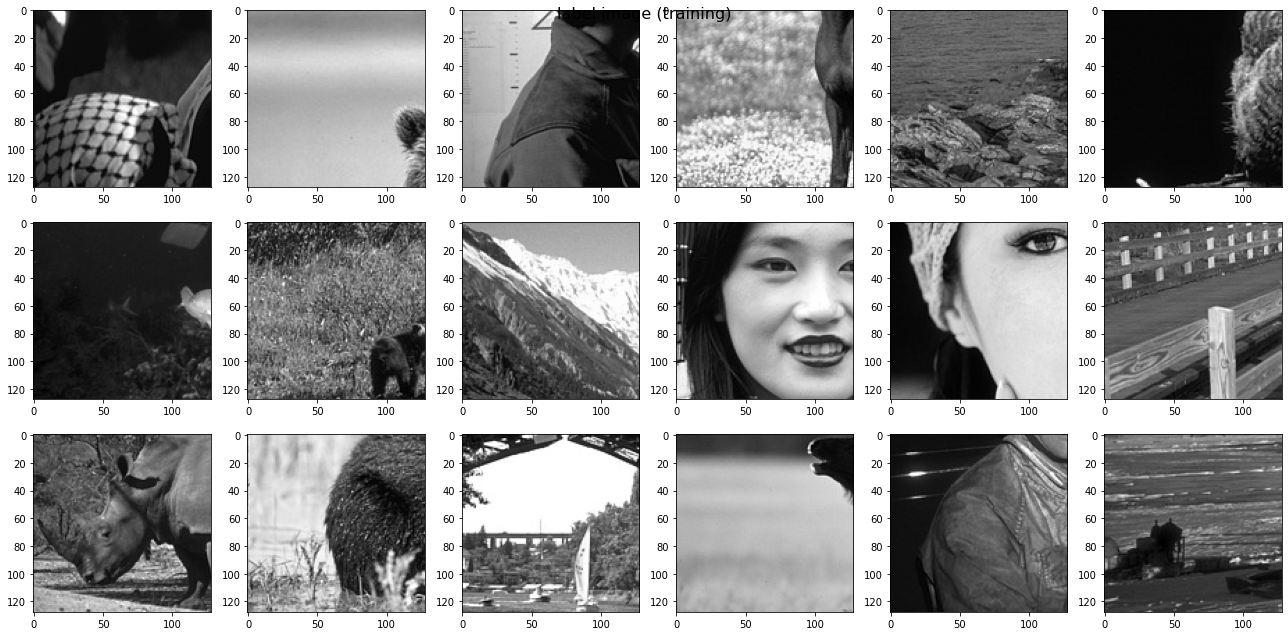

In [73]:
plot_image('label image (training)', clean_image_train)

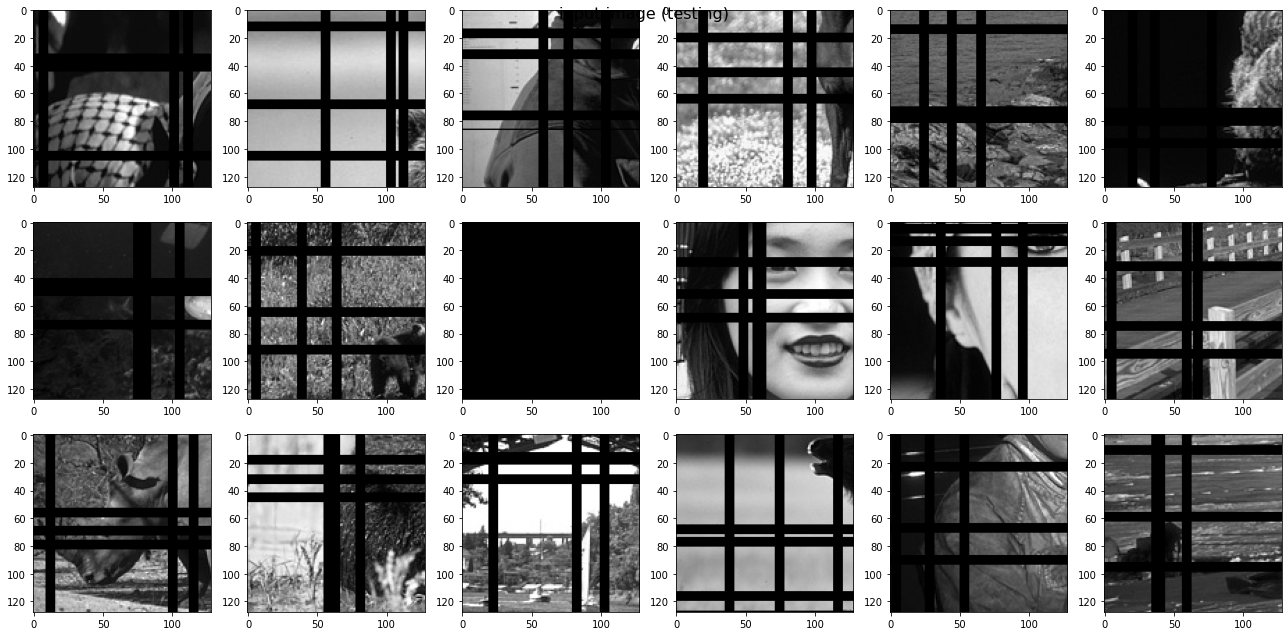

In [70]:
plot_image('input image (testing)', input_image_train)

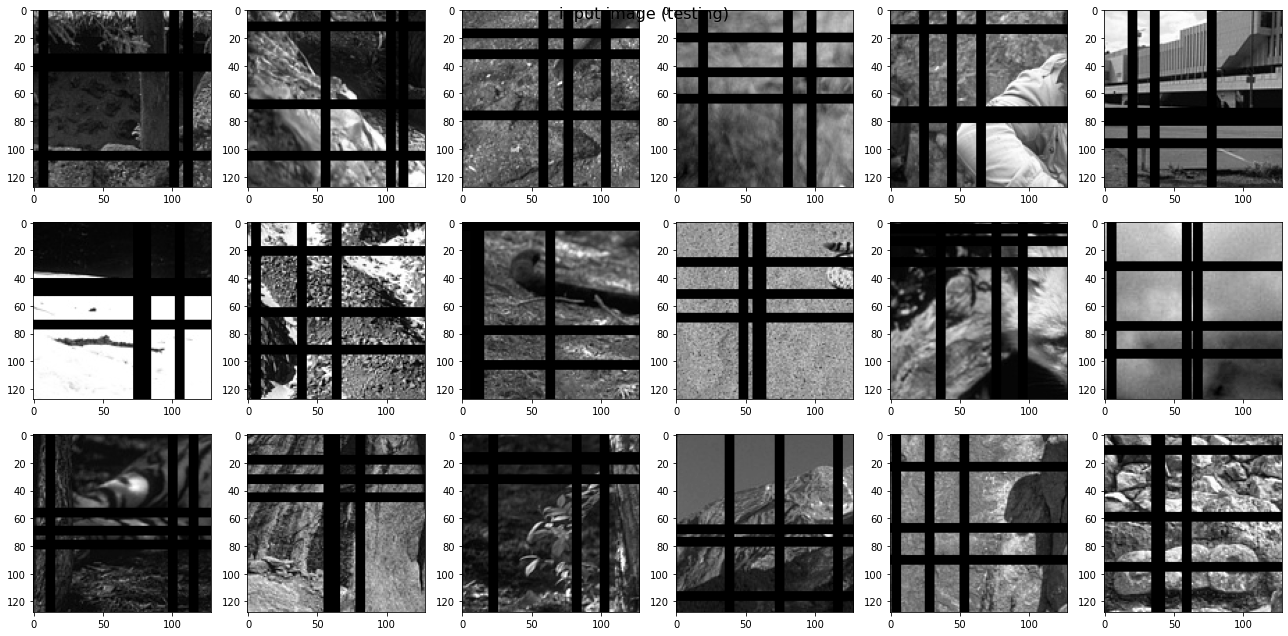

In [71]:
plot_image('input image (testing)', input_image_test)

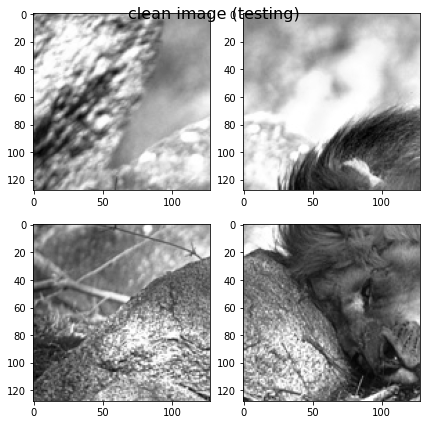

In [30]:
plot_image('clean image (testing)', clean_image_test)

## custom data loader for the training data

In [ ]:
class dataset(Dataset):
    
    def __init__(self, clean_image):
        
        self.clean_image = clean_image

    def __getitem__(self, index):
        # ==================================================
        # modify the codes for training data
        #        
        clean_image = self.clean_image[index]
        clean_image = torch.FloatTensor(clean_image).unsqueeze(dim=0)


        return (clean_image, input_image) # trainingdata도 반환하게 하기, 영상 16:31
        #    
        # ==================================================

    def __len__(self):

        number_image = self.clean_image.shape[0]

        return number_image    

## setting device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [ ]:
print(device)

mps


## custom data loader for the testing data

In [ ]:
input_image_test = torch.FloatTensor(input_image_test).unsqueeze(dim=1)
clean_image_test = torch.FloatTensor(clean_image_test).unsqueeze(dim=1)

input_image_test = input_image_test.to(device)
clean_image_test = clean_image_test.to(device)

## construct datasets and dataloaders for training and testing

In [ ]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 1
#
# ==================================================

dataset_train       = dataset(clean_image_train)
dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)

## construct a neural network 

In [ ]:
#0~1 sigmoid, sigmoid 말고 다른 것 써도 됨

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.e_layer1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),  
                        nn.MaxPool2d(2,2),
                        nn.ReLU(),
                        nn.BatchNorm2d(2),
        )
        
        self.e_layer2 = nn.Sequential(
                        nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.MaxPool2d(2,2),
                        nn.ReLU(),
                        nn.BatchNorm2d(4),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.d_layer1 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                        nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(2),
        )
        
        self.d_layer2 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                        nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
                        self.e_layer1,
                        self.e_layer2,
                        self.d_layer1, 
                        self.d_layer2,
        )

        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [ ]:
model = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#

optimizer = 

#
# ==================================================

## compute the prediction

In [ ]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the PSNR metric

- data1 : mini-batch-size x channel x height x width (torch tensor)
- data2 : mini-batch-size x channel x height x width (torch tensor)

In [ ]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [ ]:
psnr_test = np.zeros(number_epoch)

## train

In [ ]:
def train(model, optimizer, dataloader):

    model.train()

    # ==================================================
    # fill up the blank
    #




    #
    # ==================================================

## test

In [ ]:
def test(model, input_image, clean_image):

    model.eval()

    num_steps   = 40
    steps       = np.linspace(0, input_image.shape[0], num_steps+1).astype(int)
    psnr_steps  = np.zeros(num_steps)
    
    for i in range(num_steps):
        input           = input_image[steps[i]:steps[i+1], :, :, :]
        clean           = clean_image[steps[i]:steps[i+1], :, :, :]
        prediction      = compute_prediction(model, input)
        psnr_steps[i]   = compute_psnr(clean, prediction)
    
    psnr = psnr_steps.mean()
    
    return psnr

## train and test

In [ ]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    train(model, optimizer, dataloader_train)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    psnr            = test(model, input_image_test, clean_image_test)
    psnr_test[i]    = psnr

---

## functions for presenting the results

---

In [ ]:
def function_result_01():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(psnr_test, '-')
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_02():
    
    nRow = 9
    nCol = 4
    size = 3
    
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    model.eval()

    prediction  = compute_prediction(model, input_image_test)

    input_image = input_image_test.detach().cpu().squeeze(axis=1)
    clean_image = clean_image_test.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)

    nStep = 3

    for r in range(3):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
            axes[0 + r * nStep, c].imshow(input_image[k], cmap='gray')
            axes[1 + r * nStep, c].imshow(clean_image[k], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(prediction[k], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_03():
    
    print('final testing psnr = %9.8f' % (psnr_test[-1]))

---

## results 

---

In [ ]:
number_result = 3 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1)
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)